# Using Arbitrary SEDs to determine k-corrections

Quick notebook showing an example of loading a spectrum and using it to compute K-corrections. Note that all spectra must be input using Angstroms for the wavelenth unit. For K-corrections, the units of flux don't matter, as it is only the shape of the spectrum that counts. In fact, since we warp the spectrum to match the input photometry, it's the shape of the spectral features that really count.

For this example, I'm using a well-sampled object (photometrically):  SN2013aa. We have a few spectra for this object. So let's load `snpy`, set `matplotlib` stuff and load up the data (incluced in this folder):

In [1]:
from snpy import get_sn
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
s = get_sn('SN2006ax.txt')

Now we'll set up interpolators for each filter, which will be required to interpolate the photometry and do the k-corrections.

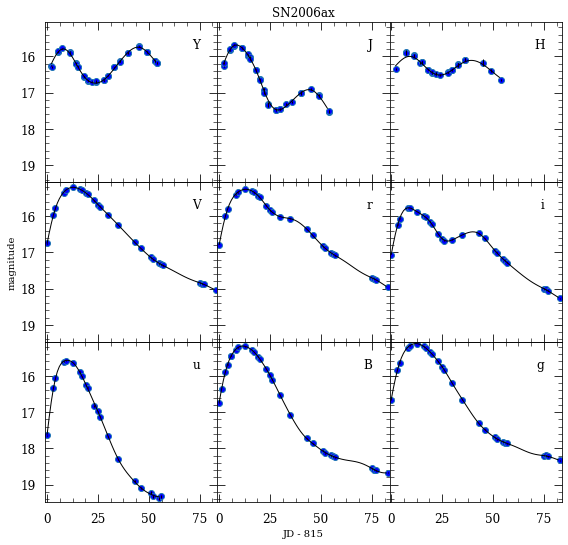

In [2]:
for filt in s.data:
    s.data[filt].curve_fit(method='gp', Nboot=10)
s.plot()

Now we load in a spectrum using `astropy.io.fits` module. We'll get the `JD` header keyword to figure out the date of obervation so we can determine the photometry on that day. We'll also use `astropy`'s `WCS` module to convert the pixels of the `FITS` file into wavelengths.

Text(0,0.5,'Flux (erg/s/cm^2/Angstrom)')

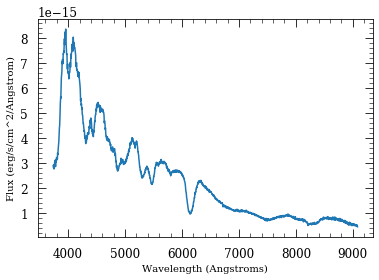

In [12]:
from astropy.io import fits
from astropy.wcs import WCS
fts = fits.open('SN06ax_b01_DUP_WF_02apr06.fits')
header = fts[0].header
JD = header['JD'] - 2453000    # the LC time axis is relative to JD=2453000
# Next, use WCS (World Coordinate System) to convert pixels to wavelengths
flux = fts[0].data
w = WCS(header)
# pix2word converts the pixels (which we get using np.indices) to world coordinates
#  in this case wavelength. The 0 arguments lets WCS know numpy counts from 0
wave = w.wcs_pix2world(np.indices(flux.shape).T, 0)   
wave = wave[:,0]    # spectrum is 1D, so only need the first axis
wave = wave/(1+s.z) # SNooPy's k-corr code expects spectra in the rest-frame
fig,ax = plt.subplots(1)
ax.plot(wave, flux)
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (erg/s/cm^2/Angstrom)')

Looks good. Now all we need to do is interpolate the photometry at the epoch of the spectrum.

In [4]:
filters = ['u','B','V','r','i']
mags = []  # interpolated magnitudes
mask = []  # boolean array that tells us if the photometry is valid
for f in filters:
    mag,flag = s.data[f].interp(JD)
    mags.append(mag)
    mask.append(flag)
mags = np.array(mags)
mask = np.array(mask)
print mags
print mask

[15.60757903 15.17711324 15.20861689 15.26519031 15.85581576]
[ True  True  True  True  True]


Let's see what the spectrum says the magnitudes should be. This is not required to compute the k-corrections,
but it shows how you can compute synthetic magnitudes from a spectrum, which might be useful in
other situations.

In [5]:
from snpy import fset     # fset is the filter-set, a dictionary of all filters in SNooPy
synth_mags = np.array([fset[f].synth_mag(wave,flux) for f in filters])
print synth_mags

[        nan         nan 15.2707061  15.3181708  15.81244642]


If line 2's syntax looks weird, it's called a list comprehension. It's the same as a for loop, just in a 
single line of code. The `nan` values indicate that the spectrum does not cover the filters u and B. We can 
see this if we plot the filters on top of the SED:

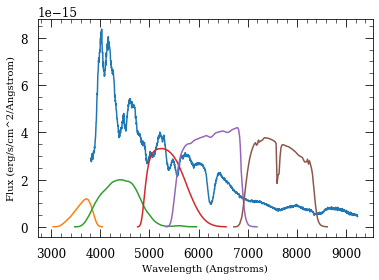

In [6]:
[ax.plot(fset[f].wave, fset[f].flux*5e-15) for f in filters]
fig

So we will only use V, r, and i to warp the spectrum. The function to use to compute k-corrections with an arbitrary spectrum is `snpy.kcorr.kcorr_mangle2`. You need to give it several arguments:

* wave,flux:  the spectrum you are using

* filts:  list of filters to use

* mags:  array of magnitudes for the filters

* m_mask:  a boolean array indicating good/bad data in mags

* restfilts: list of rest-frame filters. At low-z, these are the same as filts.

* z:  redshift of the SN

We've already got most of what we need. For the mask, we'll use `synth_mags` array we
created earlier as a way to tell the function what values are "bad".

In [15]:
from snpy.kcorr import kcorr_mangle2
k,flag = kcorr_mangle2(wave, flux, filters, mags, mask, filters, s.z)
print k
print flag

Warning! The following filters were not covered by the SED:
u,B
[ 0.          0.         -0.00320931 -0.04814717 -0.04788486]
[0 0 5 5 5]


The K-corrections should be *subtracted* from the photometry to correct it (i.e., put it in the observer frame). 
Note that the the k-corrections for `u` and `B` filters are zero, since they could not be computed from this
spectrum.  The `flag` variable shows this, as its value is 0 for those two filers. The other values (5) indicate
the number of photometric points input to constrain the "mangling". 

Now, let's do this for many spectra "all at once". This will bring together everything above into a loop over
the spectra to build up the arrays we need.

Warning! The following filters were not covered by the SED:
u,B
Warning! The following filters were not covered by the SED:
u,B
Warning! The following filters were not covered by the SED:
u,B
Warning! The following filters were not covered by the SED:
u,B
Warning! The following filters were not covered by the SED:
u,B
Warning! The following filters were not covered by the SED:
u,B
Warning! The following filters were not covered by the SED:
u,B


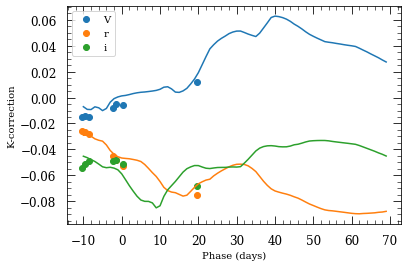

In [18]:
import glob
from snpy.kcorr import kcorr
spectra = glob.glob('*.fits')   # get listing of all .fits files
JDs = []
kcorrs = []
masks = []
for spectrum in spectra:
    fts = fits.open(spectrum)
    flux = fts[0].data
    header = fts[0].header
    JD = header['JD'] - 2453000
    JDs.append(JD)
    w = WCS(header)
    wave = w.wcs_pix2world(np.indices(flux.shape).T, 0)
    wave = wave[:,0]/(1+s.z)

    mags = np.array([s.data[f].interp(JD)[0] for f in filters])
    mask = np.array([s.data[f].interp(JD)[1] for f in filters])
    
    ks,flag = kcorr_mangle2(wave,flux, filters, mags, mask, filters, s.z, method='bspline')
    kcorrs.append(ks)
    masks.append(flag > 0)
kcorrs = np.array(kcorrs)
JDs = np.array(JDs)
fig2,ax2 = plt.subplots(1)
l1, = ax2.plot(JDs - s.B.Tmax, kcorrs[:,2], 'o', label='V')
l2, = ax2.plot(JDs - s.B.Tmax, kcorrs[:,3], 'o', label='r')
l3, = ax2.plot(JDs - s.B.Tmax, kcorrs[:,4], 'o', label='i')

# Now compare with unmodified Hsiao SED
x = np.arange(-10,70)
ks = kcorr(x, 'V','V',s.z)[0]
ax2.plot(x,ks,'-', color=l1.get_color())
ks = kcorr(x, 'r','r',s.z)[0]
ax2.plot(x,ks,'-', color=l2.get_color())
ks = kcorr(x, 'i','i',s.z)[0]
ax2.plot(x,ks,'-', color=l3.get_color())
ax2.set_xlabel('Phase (days)')
ax2.set_ylabel('K-correction')
ax2.legend()